# Fine-tuning SBERT with Contrastive Learning

This notebook fine-tunes a Sentence-BERT model using contrastive learning on **job-to-job pairs**.

## Approach
- **Loss Function**: Contrastive Loss (brings positive pairs closer, pushes negative pairs apart)
- **Base Model**: all-MiniLM-L6-v2
- **Training Strategy**: Siamese network architecture with shared weights
- **Data**: Job description pairs (similar vs dissimilar jobs)

In [1]:
!pip install sentence-transformers datasets torch transformers scikit-learn matplotlib seaborn tqdm -q

In [ ]:

import os

os.environ["USE_TF"] = "0"
os.environ["USE_TORCH"] = "1"

import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## 1. Load Training Data

In [3]:
# Load the synthetic job-to-job pairs
train_df = pd.read_csv("train_pairs.csv")
val_df = pd.read_csv("val_pairs.csv")
test_df = pd.read_csv("test_pairs.csv")

print(f"Train set: {len(train_df)} pairs")
print(f"Validation set: {len(val_df)} pairs")
print(f"Test set: {len(test_df)} pairs")

print(f"\nClass distribution (train):")
print(train_df["label"].value_counts())

print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nSample row:")
print(train_df.iloc[0][["job1_title", "job2_title", "label", "skill_overlap"]])

Train set: 4200 pairs
Validation set: 900 pairs
Test set: 900 pairs

Class distribution (train):
label
1    2100
0    2100
Name: count, dtype: int64

Columns: ['job1_idx', 'job2_idx', 'skill_overlap', 'embedding_similarity', 'same_title', 'label', 'job1_text', 'job2_text', 'job1_title', 'job2_title']

Sample row:
job1_title                                    Sales Representative
job2_title       Inside Sales Account Manager w/ Base + Commiss...
label                                                            1
skill_overlap                                                  1.0
Name: 0, dtype: object


## 2. Prepare Data for Sentence-Transformers

In [4]:
def create_input_examples(df):
    """
    Convert DataFrame to InputExample format for sentence-transformers
    InputExample expects: texts=[text1, text2], label=float

    For contrastive loss:
    - label=1.0 means similar (positive pair)
    - label=0.0 means dissimilar (negative pair)
    """
    examples = []
    for idx, row in df.iterrows():
        example = InputExample(
            texts=[row["job1_text"], row["job2_text"]], label=float(row["label"])
        )
        examples.append(example)
    return examples


print("Creating training examples...")
train_examples = create_input_examples(train_df)
print(f"Created {len(train_examples)} training examples")

print("\nSample training example:")
print(f"Job 1: {train_examples[0].texts[0][:150]}...")
print(f"Job 2: {train_examples[0].texts[1][:150]}...")
print(f"Label: {train_examples[0].label}")

Creating training examples...
Created 4200 training examples

Sample training example:
Job 1: Job Title: Sales Representative. Description: The Sales Representative will be responsible for prospecting new businesses and developing relationships...
Job 2: Job Title: Inside Sales Account Manager w/ Base + Commissions. Description: We are looking to grow our inside sales team in the Columbus area.  We are...
Label: 1.0


## 3. Load Pre-trained Model

In [5]:
# Load the base model
model_name = "all-MiniLM-L6-v2"
print(f"Loading base model: {model_name}...")
model = SentenceTransformer(model_name)

print(f"\nModel architecture:")
print(model)

print(f"\nEmbedding dimension: {model.get_sentence_embedding_dimension()}")

Loading base model: all-MiniLM-L6-v2...

Model architecture:
SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

Embedding dimension: 384


## 4. Set Up Data Loader

In [6]:
# Training parameters
BATCH_SIZE = 16  # Adjust based on GPU memory
NUM_EPOCHS = 4
WARMUP_STEPS = 100
EVALUATION_STEPS = 500

# Create data loader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Total training steps: {len(train_dataloader) * NUM_EPOCHS}")

Number of training batches: 263
Total training steps: 1052


## 5. Define Loss Function

In [7]:
# Contrastive Loss
# This loss function pulls similar pairs (label=1) together and pushes dissimilar pairs (label=0) apart
train_loss = losses.ContrastiveLoss(model=model)

print("Using Contrastive Loss:")
print("  - Positive pairs (label=1): Minimize distance between similar jobs")
print(
    "  - Negative pairs (label=0): Maximize distance between dissimilar jobs (up to margin)"
)

Using Contrastive Loss:
  - Positive pairs (label=1): Minimize distance between similar jobs
  - Negative pairs (label=0): Maximize distance between dissimilar jobs (up to margin)


## 6. Set Up Evaluator

In [8]:
# Create evaluation examples
val_examples = create_input_examples(val_df)

# Binary classification evaluator
# This evaluator computes cosine similarity between pairs and evaluates classification performance
evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=[ex.texts[0] for ex in val_examples],
    sentences2=[ex.texts[1] for ex in val_examples],
    labels=[ex.label for ex in val_examples],
    name="job-job-matching",
    show_progress_bar=True,
)

print(f"Evaluator created with {len(val_examples)} validation examples")

Evaluator created with 900 validation examples


## 7. Train the Model

In [9]:
# Create output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = f"./models/job-matcher_{timestamp}"
os.makedirs(output_path, exist_ok=True)

print(f"Model will be saved to: {output_path}")
print(f"\nStarting training...\n")

Model will be saved to: ./models/job-matcher_20251121_123928

Starting training...



In [10]:
# Train the model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=NUM_EPOCHS,
    evaluation_steps=EVALUATION_STEPS,
    warmup_steps=WARMUP_STEPS,
    output_path=output_path,
    save_best_model=True,
    show_progress_bar=True,
    use_amp=False,  # Set to True if you have GPU with mixed precision support
)

print("\nTraining completed!")
print(f"Best model saved to: {output_path}")

  0%|          | 0/1052 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

{'loss': 0.0052, 'grad_norm': 0.07129082083702087, 'learning_rate': 1.1561181434599158e-05, 'epoch': 1.9}


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

{'eval_job-job-matching_cosine_accuracy': 0.9933333333333333, 'eval_job-job-matching_cosine_accuracy_threshold': 0.5431393384933472, 'eval_job-job-matching_cosine_f1': 0.993362831858407, 'eval_job-job-matching_cosine_f1_threshold': 0.5431393384933472, 'eval_job-job-matching_cosine_precision': 0.9889867841409692, 'eval_job-job-matching_cosine_recall': 0.9977777777777778, 'eval_job-job-matching_cosine_ap': 0.9990698970738098, 'eval_runtime': 1.9105, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0, 'epoch': 1.9}


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0004, 'grad_norm': 0.029628871008753777, 'learning_rate': 1.0126582278481013e-06, 'epoch': 3.8}


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

{'eval_job-job-matching_cosine_accuracy': 0.9922222222222222, 'eval_job-job-matching_cosine_accuracy_threshold': 0.49437522888183594, 'eval_job-job-matching_cosine_f1': 0.9922651933701657, 'eval_job-job-matching_cosine_f1_threshold': 0.49437522888183594, 'eval_job-job-matching_cosine_precision': 0.9868131868131869, 'eval_job-job-matching_cosine_recall': 0.9977777777777778, 'eval_job-job-matching_cosine_ap': 0.9994223069451524, 'eval_runtime': 1.8357, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0, 'epoch': 3.8}


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

{'train_runtime': 289.3886, 'train_samples_per_second': 58.053, 'train_steps_per_second': 3.635, 'train_loss': 0.002688196590418145, 'epoch': 4.0}

Training completed!
Best model saved to: ./models/job-matcher_20251121_123928


## 8. Evaluate on Test Set

In [12]:
# Load the best model
print("Loading best model for evaluation...")
best_model = SentenceTransformer(output_path)

# Create test evaluator
test_examples = create_input_examples(test_df)
test_evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=[ex.texts[0] for ex in test_examples],
    sentences2=[ex.texts[1] for ex in test_examples],
    labels=[ex.label for ex in test_examples],
    name="test-set",
    show_progress_bar=True,
)

# Evaluate
print("\nEvaluating on test set...")
test_score = test_evaluator(best_model)
# print(f"Test set performance (accuracy): {test_score:.4f}")

Loading best model for evaluation...

Evaluating on test set...


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

## 9. Detailed Performance Analysis

In [13]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.metrics.pairwise import cosine_similarity

# Get predictions on test set
print("Computing embeddings for test set...")
job1_embeddings = best_model.encode(
    [ex.texts[0] for ex in test_examples], show_progress_bar=True
)
job2_embeddings = best_model.encode(
    [ex.texts[1] for ex in test_examples], show_progress_bar=True
)

# Compute cosine similarities
similarities = np.array(
    [
        cosine_similarity([job1_embeddings[i]], [job2_embeddings[i]])[0][0]
        for i in range(len(test_examples))
    ]
)

# Get true labels
true_labels = np.array([ex.label for ex in test_examples])

print(f"\nSimilarity score statistics:")
print(f"  Min: {similarities.min():.4f}")
print(f"  Max: {similarities.max():.4f}")
print(f"  Mean: {similarities.mean():.4f}")
print(f"  Std: {similarities.std():.4f}")

print(f"\nPositive pairs - Mean similarity: {similarities[true_labels==1].mean():.4f}")
print(f"Negative pairs - Mean similarity: {similarities[true_labels==0].mean():.4f}")

Computing embeddings for test set...


Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Batches:   0%|          | 0/29 [00:00<?, ?it/s]


Similarity score statistics:
  Min: -0.0315
  Max: 1.0000
  Mean: 0.6463
  Std: 0.3438

Positive pairs - Mean similarity: 0.9828
Negative pairs - Mean similarity: 0.3098


In [14]:
# Find optimal threshold
from sklearn.metrics import accuracy_score

thresholds = np.arange(0.0, 1.0, 0.01)
accuracies = []

for thresh in thresholds:
    pred_labels = (similarities >= thresh).astype(int)
    acc = accuracy_score(true_labels, pred_labels)
    accuracies.append(acc)

optimal_threshold = thresholds[np.argmax(accuracies)]
optimal_accuracy = max(accuracies)

print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print(f"Optimal accuracy: {optimal_accuracy:.4f}")


Optimal threshold: 0.630
Optimal accuracy: 0.9967


In [15]:
# Get predictions with optimal threshold
pred_labels = (similarities >= optimal_threshold).astype(int)

# Classification report
print("\nClassification Report:")
print(
    classification_report(
        true_labels, pred_labels, target_names=["Dissimilar", "Similar"]
    )
)

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("\nConfusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

  Dissimilar       1.00      0.99      1.00       450
     Similar       0.99      1.00      1.00       450

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900


Confusion Matrix:
[[447   3]
 [  0 450]]


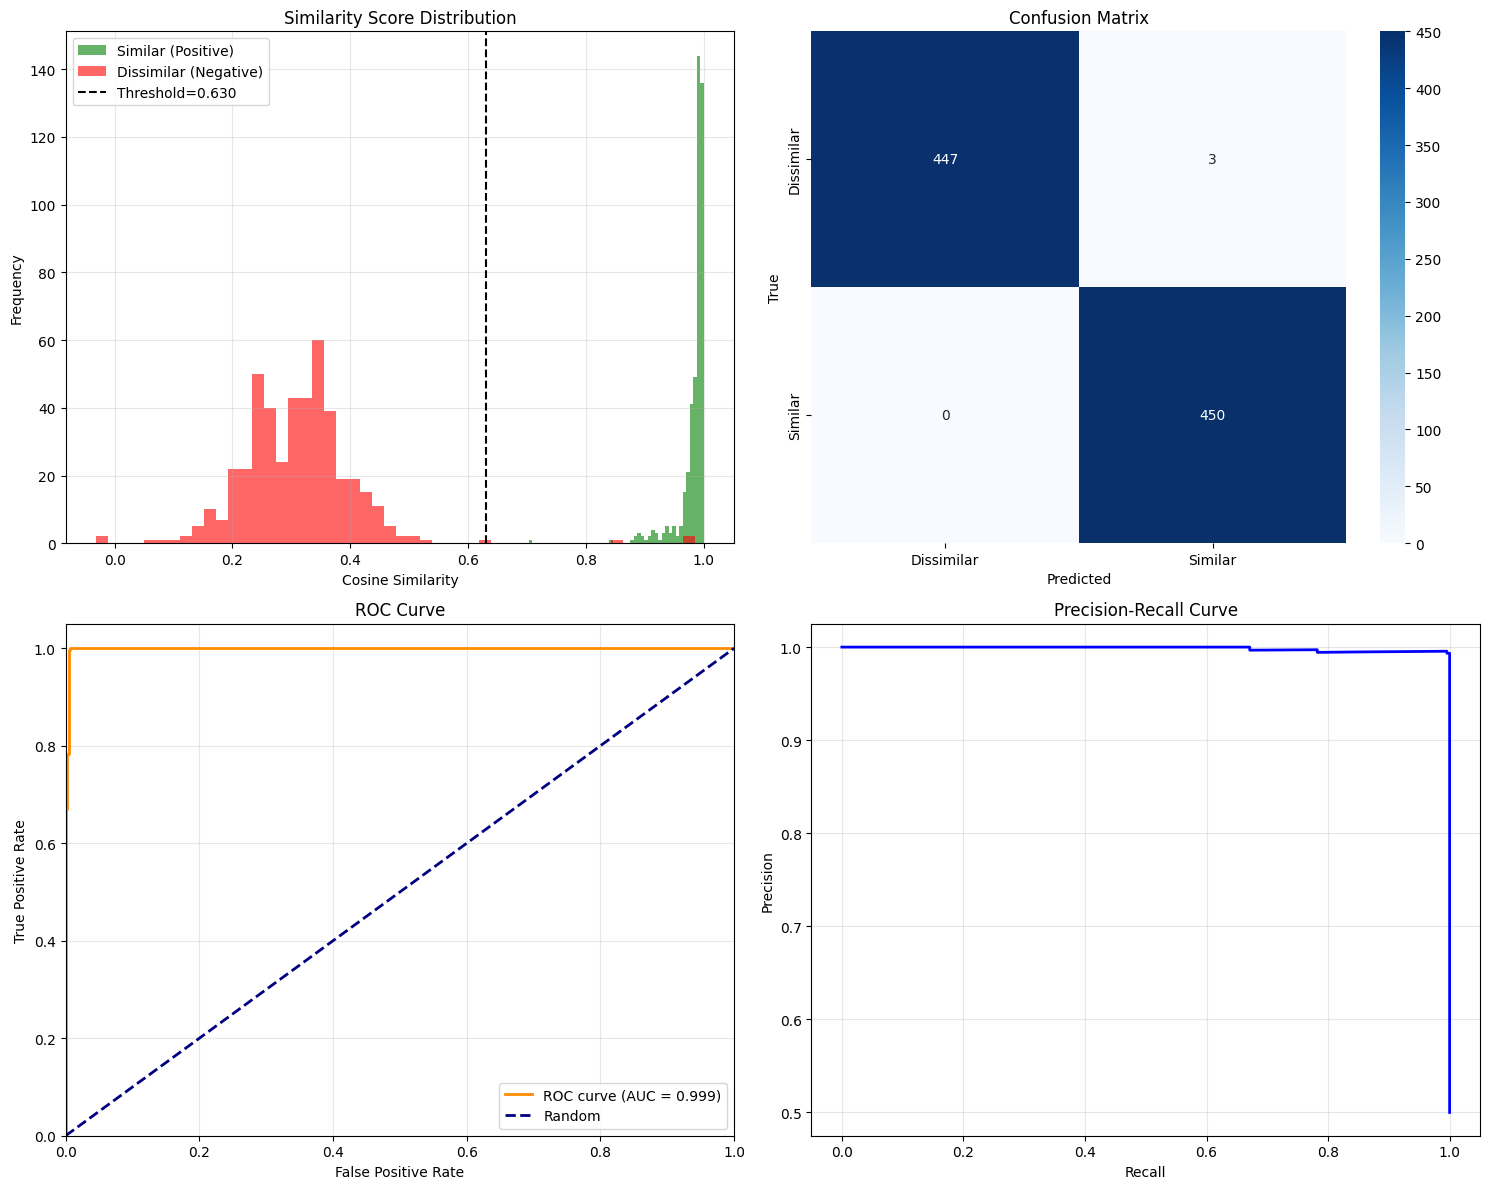


Evaluation plots saved to: ./models/job-matcher_20251121_123928/evaluation_metrics.png


In [16]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Similarity distribution by class
axes[0, 0].hist(
    similarities[true_labels == 1],
    bins=50,
    alpha=0.6,
    label="Similar (Positive)",
    color="green",
)
axes[0, 0].hist(
    similarities[true_labels == 0],
    bins=50,
    alpha=0.6,
    label="Dissimilar (Negative)",
    color="red",
)
axes[0, 0].axvline(
    optimal_threshold,
    color="black",
    linestyle="--",
    label=f"Threshold={optimal_threshold:.3f}",
)
axes[0, 0].set_xlabel("Cosine Similarity")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Similarity Score Distribution")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 1])
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("True")
axes[0, 1].set_title("Confusion Matrix")
axes[0, 1].set_xticklabels(["Dissimilar", "Similar"])
axes[0, 1].set_yticklabels(["Dissimilar", "Similar"])

# 3. ROC curve
fpr, tpr, _ = roc_curve(true_labels, similarities)
roc_auc = auc(fpr, tpr)
axes[1, 0].plot(
    fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})"
)
axes[1, 0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random")
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel("False Positive Rate")
axes[1, 0].set_ylabel("True Positive Rate")
axes[1, 0].set_title("ROC Curve")
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(alpha=0.3)

# 4. Precision-Recall curve
precision, recall, _ = precision_recall_curve(true_labels, similarities)
axes[1, 1].plot(recall, precision, color="blue", lw=2)
axes[1, 1].set_xlabel("Recall")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].set_title("Precision-Recall Curve")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_path}/evaluation_metrics.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nEvaluation plots saved to: {output_path}/evaluation_metrics.png")

## 10. Test on Real Examples

In [17]:
# Example usage: Find most similar jobs
def find_similar_jobs(
    query_job_text, candidate_job_texts, model, top_k=5, threshold=None
):
    """
    Find top-k most similar jobs to the query job
    """
    # Encode query and candidates
    query_embedding = model.encode([query_job_text])
    candidate_embeddings = model.encode(candidate_job_texts)

    # Compute similarities
    similarities = cosine_similarity(query_embedding, candidate_embeddings)[0]

    # Get top-k indices
    top_indices = np.argsort(similarities)[::-1][:top_k]

    results = []
    for idx in top_indices:
        is_match = similarities[idx] >= threshold if threshold else None
        results.append(
            {"index": idx, "similarity": similarities[idx], "is_match": is_match}
        )

    return results


# Test on a sample job from test set
sample_idx = 0
sample_job1 = test_examples[sample_idx].texts[0]
sample_job1_title = test_df.iloc[sample_idx]["job1_title"]

# Get all other jobs from test set
all_jobs = [ex.texts[1] for ex in test_examples]
all_job_titles = test_df["job2_title"].tolist()

print("Query Job:")
print(f"Title: {sample_job1_title}")
print(f"Text: {sample_job1[:300]}...\n")

print("Finding top 5 most similar jobs...\n")
matches = find_similar_jobs(
    sample_job1, all_jobs, best_model, top_k=5, threshold=optimal_threshold
)

for i, match in enumerate(matches, 1):
    print(f"\nRank {i}:")
    print(f"  Job Title: {all_job_titles[match['index']]}")
    print(f"  Similarity: {match['similarity']:.4f}")
    print(f"  Is Match: {match['is_match']}")
    print(f"  Text: {all_jobs[match['index']][:200]}...")

Query Job:
Title: Resident Nurse
Text: Job Title: Resident Nurse. Description: Service Desk Officer - Network Operations Center Watch Administrator position is in support of a Government Solutions customer in the Northern Virginia area. This position is for 12 hour shifts (nights), which runs from 6PM to 6AM, over a two week rotating sch...

Finding top 5 most similar jobs...


Rank 1:
  Job Title: Resident Nurse
  Similarity: 0.9965
  Is Match: True
  Text: Job Title: Resident Nurse. Description: AT&T IT Service Delivery Rep Senior is considered a Site Lead for the servicing of a large scale Enterprise network. Successful Sr. ITSDRs provide the required ...

Rank 2:
  Job Title: Resident Nurse
  Similarity: 0.9959
  Is Match: True
  Text: Job Title: Resident Nurse. Description: Installs, maintains, and services IP network and transport service hardware and software under limited supervision. Demonstrates knowledge of and skill with Ope...

Rank 3:
  Job Title: Resident Nurse
  Similar

## 11. Compare with Base Model

In [18]:
# Load original base model
base_model = SentenceTransformer("all-MiniLM-L6-v2")

# Evaluate base model on test set
print("Evaluating base (non-fine-tuned) model...")
base_job1_embeddings = base_model.encode(
    [ex.texts[0] for ex in test_examples], show_progress_bar=True
)
base_job2_embeddings = base_model.encode(
    [ex.texts[1] for ex in test_examples], show_progress_bar=True
)

base_similarities = np.array(
    [
        cosine_similarity([base_job1_embeddings[i]], [base_job2_embeddings[i]])[0][0]
        for i in range(len(test_examples))
    ]
)

# Find optimal threshold for base model
base_accuracies = []
for thresh in thresholds:
    pred_labels = (base_similarities >= thresh).astype(int)
    acc = accuracy_score(true_labels, pred_labels)
    base_accuracies.append(acc)

base_optimal_threshold = thresholds[np.argmax(base_accuracies)]
base_optimal_accuracy = max(base_accuracies)

print(f"\nBase Model:")
print(f"  Optimal threshold: {base_optimal_threshold:.3f}")
print(f"  Optimal accuracy: {base_optimal_accuracy:.4f}")
print(f"  Mean similarity (positive): {base_similarities[true_labels==1].mean():.4f}")
print(f"  Mean similarity (negative): {base_similarities[true_labels==0].mean():.4f}")

print(f"\nFine-tuned Model:")
print(f"  Optimal threshold: {optimal_threshold:.3f}")
print(f"  Optimal accuracy: {optimal_accuracy:.4f}")
print(f"  Mean similarity (positive): {similarities[true_labels==1].mean():.4f}")
print(f"  Mean similarity (negative): {similarities[true_labels==0].mean():.4f}")

improvement = (optimal_accuracy - base_optimal_accuracy) * 100
print(f"\nImprovement: {improvement:.2f} percentage points")

# Separation metric: difference in mean similarities
base_separation = (
    base_similarities[true_labels == 1].mean()
    - base_similarities[true_labels == 0].mean()
)
finetuned_separation = (
    similarities[true_labels == 1].mean() - similarities[true_labels == 0].mean()
)

print(f"\nSeparation (positive - negative mean):")
print(f"  Base model: {base_separation:.4f}")
print(f"  Fine-tuned model: {finetuned_separation:.4f}")
print(f"  Improvement: {(finetuned_separation - base_separation):.4f}")

Evaluating base (non-fine-tuned) model...


Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Batches:   0%|          | 0/29 [00:00<?, ?it/s]


Base Model:
  Optimal threshold: 0.510
  Optimal accuracy: 0.7889
  Mean similarity (positive): 0.6323
  Mean similarity (negative): 0.4526

Fine-tuned Model:
  Optimal threshold: 0.630
  Optimal accuracy: 0.9967
  Mean similarity (positive): 0.9828
  Mean similarity (negative): 0.3098

Improvement: 20.78 percentage points

Separation (positive - negative mean):
  Base model: 0.1797
  Fine-tuned model: 0.6730
  Improvement: 0.4933


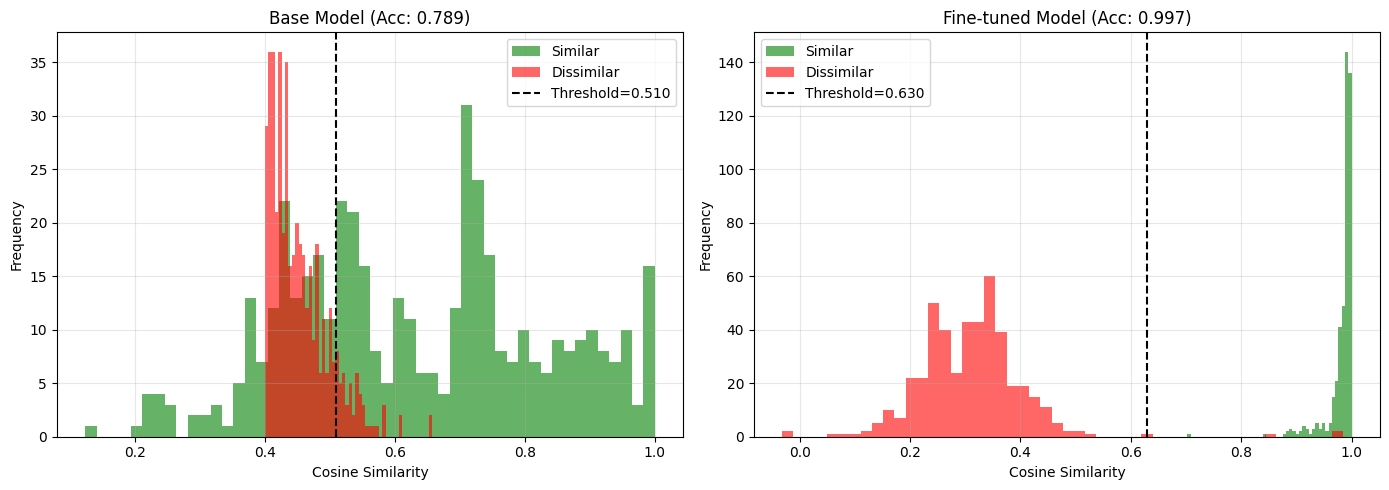


Comparison plot saved to: ./models/job-matcher_20251121_123928/model_comparison.png


In [19]:
# Side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Base model
axes[0].hist(
    base_similarities[true_labels == 1],
    bins=50,
    alpha=0.6,
    label="Similar",
    color="green",
)
axes[0].hist(
    base_similarities[true_labels == 0],
    bins=50,
    alpha=0.6,
    label="Dissimilar",
    color="red",
)
axes[0].axvline(
    base_optimal_threshold,
    color="black",
    linestyle="--",
    label=f"Threshold={base_optimal_threshold:.3f}",
)
axes[0].set_xlabel("Cosine Similarity")
axes[0].set_ylabel("Frequency")
axes[0].set_title(f"Base Model (Acc: {base_optimal_accuracy:.3f})")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Fine-tuned model
axes[1].hist(
    similarities[true_labels == 1], bins=50, alpha=0.6, label="Similar", color="green"
)
axes[1].hist(
    similarities[true_labels == 0], bins=50, alpha=0.6, label="Dissimilar", color="red"
)
axes[1].axvline(
    optimal_threshold,
    color="black",
    linestyle="--",
    label=f"Threshold={optimal_threshold:.3f}",
)
axes[1].set_xlabel("Cosine Similarity")
axes[1].set_ylabel("Frequency")
axes[1].set_title(f"Fine-tuned Model (Acc: {optimal_accuracy:.3f})")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_path}/model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nComparison plot saved to: {output_path}/model_comparison.png")

## 12. Save Model Metadata

In [20]:
# Save model metadata and performance metrics
metadata = {
    "model_name": model_name,
    "timestamp": timestamp,
    "training_params": {
        "batch_size": BATCH_SIZE,
        "num_epochs": NUM_EPOCHS,
        "warmup_steps": WARMUP_STEPS,
        "evaluation_steps": EVALUATION_STEPS,
        "loss_function": "ContrastiveLoss",
    },
    "dataset_stats": {
        "train_size": len(train_df),
        "val_size": len(val_df),
        "test_size": len(test_df),
        "train_positive_ratio": (train_df["label"] == 1).sum() / len(train_df),
    },
    "performance": {
        "test_accuracy": float(optimal_accuracy),
        "optimal_threshold": float(optimal_threshold),
        "roc_auc": float(roc_auc),
        "base_model_accuracy": float(base_optimal_accuracy),
        "improvement": float(optimal_accuracy - base_optimal_accuracy),
        "separation_improvement": float(finetuned_separation - base_separation),
        "positive_mean_similarity": float(similarities[true_labels == 1].mean()),
        "negative_mean_similarity": float(similarities[true_labels == 0].mean()),
    },
    "confusion_matrix": cm.tolist(),
}

with open(f"{output_path}/model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print(f"Model metadata saved to: {output_path}/model_metadata.json")
print("\n" + "=" * 80)
print("TRAINING COMPLETE!")
print("=" * 80)
print(f"\nFine-tuned model location: {output_path}")
print(f"Accuracy: {optimal_accuracy:.4f}")
print(f"Improvement over base model: {improvement:.2f} percentage points")

Model metadata saved to: ./models/job-matcher_20251121_123928/model_metadata.json

TRAINING COMPLETE!

Fine-tuned model location: ./models/job-matcher_20251121_123928
Accuracy: 0.9967
Improvement over base model: 20.78 percentage points


## 13. Usage Instructions

### Load and Use the Fine-tuned Model

```python
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json

# Load the model
model = SentenceTransformer('./models/job-matcher_[timestamp]')

# Load metadata for optimal threshold
with open('./models/job-matcher_[timestamp]/model_metadata.json', 'r') as f:
    metadata = json.load(f)
optimal_threshold = metadata['performance']['optimal_threshold']

# Encode job descriptions
job1_embedding = model.encode([job1_text])
job2_embedding = model.encode([job2_text])

# Calculate similarity
similarity = cosine_similarity(job1_embedding, job2_embedding)[0][0]

# Classify as match or not
is_similar = similarity >= optimal_threshold

print(f"Similarity: {similarity:.4f}")
print(f"Jobs are similar: {is_similar}")
```

### Find Similar Jobs

```python
# Encode query job
query_embedding = model.encode([query_job_text])

# Encode candidate jobs
candidate_embeddings = model.encode(candidate_job_texts)

# Compute similarities
similarities = cosine_similarity(query_embedding, candidate_embeddings)[0]

# Get top 10 most similar
top_10_indices = np.argsort(similarities)[::-1][:10]

for idx in top_10_indices:
    print(f"Job {idx}: Similarity = {similarities[idx]:.4f}")
```